In [1]:
# To run this in Google Colab, uncomment the following line
# !pip install "git+https://github.com/GPflow/GeometricKernels.git"

# If you want to use a version of the library from a different git branch,
# say, from the "devel" branch, uncomment the line below instead
# !pip install "git+https://github.com/GPflow/GeometricKernels@devel#egg=GeometricKernels"

# Matérn and Heat Kernels on the Manifold of Symmetric Positive Definite Matrices (SPD)

This notebook shows how define and evaluate kernels on the manifold of symmetric positive definite matrices $\mathbb{SPD}(2)$ of size $2 \times 2$.

Handling higher-dimensional manifolds of symmetric positive definite matrices $\mathbb{SPD}(d)$ for $d > 2$ is essentially the same.

**Note:** the points on the hyperbolic space $\mathbb{SPD}(d)$ are represented by matrices (`array`s of the suitable backend) or size $d \times d$.

We use the **numpy** backend here.

In [2]:
# Import a backend, we use numpy in this example.
import numpy as np
# Import the geometric_kernels backend.
import geometric_kernels

# Note: if you are using a backend other than numpy,
# you _must_ uncomment one of the following lines
# import geometric_kernels.tensorflow
# import geometric_kernels.torch
# import geometric_kernels.jax

# Import a space and an appropriate kernel.
from geometric_kernels.spaces import SymmetricPositiveDefiniteMatrices
from geometric_kernels.kernels import MaternGeometricKernel

import matplotlib as mpl
import matplotlib.pyplot as plt

import geomstats.visualization as visualization

INFO: Using numpy backend


## Defining a Space

First we create a GeometricKernels `space` that corresponds to the 2-dimensional manifold of symmetric positive definite matrices $\mathbb{SPD}(2)$.

In [3]:
spd = SymmetricPositiveDefiniteMatrices(2)

## Defining a Kernel

To initialize `MaternGeometricKernel` you need to provide a `Space` object, in our case this is the `hyperbolic_space` we have just created above.
Additionally, there is a mandatory keyword argument `key` which should be equal to a random generator that is **specific to the backend you are using**.
This is because `MaternGeometricKernel` on non-compact symmetric spaces is a random Monte Carlo approximation. Notably, this implies that kernel can be (slightly) different every time.

There is also an optional parameter `num` which determines the order of approximation of the kernel (*number of levels*).
There is a sensible default value for each of the spaces in the library, so change it only if you know what you are doing.

A brief account on theory behind the kernels on non-compact symmetric spaces (which hyperbolic spaces are instances of) can be found on this [documentation page](https://gpflow.github.io/GeometricKernels/theory/symmetric.html).

First, we define randomness

In [4]:
key = np.random.RandomState(seed=1234)

Now we are ready to create a generic Matérn kernel.

In [5]:
kernel = MaternGeometricKernel(spd, key=key)

To support JAX, our classes do not keep variables you might want to differentiate over in their state.
Instead, some methods take a `params` dictionary as input, returning its modified version.

The next line initializes the dictionary of kernel parameters `params` with some default values.

**Note:** our kernels do not contain the outputscale/variance parameter frequently used in Gaussian processes.
However, it is usually trivial to add it by multiplying the kernel by an (optimizable) constant.

In [6]:
params = kernel.init_params()
print('params:', params)

params: {'nu': array(inf), 'lengthscale': array(1.)}


To define two different kernels, Matern-3/2 and Matern-∞ (aka heat, RBF, squared exponential, diffusion), we need two different versions of `params`:

In [7]:
params["lengthscale"] = np.array([0.5])
params_32  = params.copy()
params_inf = params.copy()
del params
params_32["nu"]  = np.array([3/2])
params_inf["nu"] = np.array([np.inf])

Now two kernels are *defined* and we proceed to evaluating both on a set of random inputs.

## Evaluating Kernels on Random Inputs

We start by sampling `10` random points on the sphere $\mathbb{H}_2$.
Since manifolds of positive definite matrices are noncompact, the sampling cannot be uniform.
Here we resort to the default sampling routine from the [geomstats](https://geomstats.github.io/index.html) package.

In [8]:
xs = spd.random_point(10)

print(xs)

[[[ 1.41134064 -0.36427146]
  [-0.36427146  0.77058065]]

 [[ 0.60484911  0.01414122]
  [ 0.01414122  2.03196849]]

 [[ 1.72574649  1.16282237]
  [ 1.16282237  2.48324756]]

 [[ 1.63287918 -0.4918052 ]
  [-0.4918052   0.57638297]]

 [[ 1.74897003  0.77130086]
  [ 0.77130086  1.10715524]]

 [[ 2.41124537 -0.02256206]
  [-0.02256206  1.67637266]]

 [[ 1.51361227  0.71680947]
  [ 0.71680947  0.91667888]]

 [[ 2.65599251  0.58109341]
  [ 0.58109341  0.9495582 ]]

 [[ 2.75392333 -1.15362902]
  [-1.15362902  1.34107138]]

 [[ 0.55435838 -0.09556785]
  [-0.09556785  0.4225248 ]]]


Now we evaluate the two kernel matrices.

In [9]:
kernel_mat_32  = kernel.K(params_32,  xs, xs)
kernel_mat_inf = kernel.K(params_inf, xs, xs)

Finally, we visualize these matrices using `imshow`.

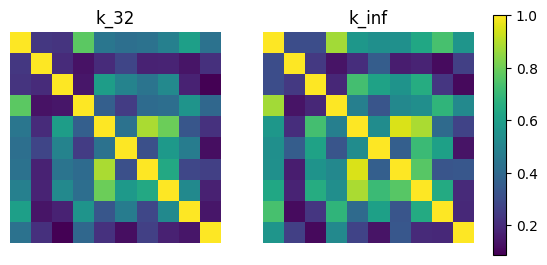

In [10]:
# find common range of values
minmin = np.min([np.min(kernel_mat_32), np.min(kernel_mat_inf)])
maxmax = np.max([np.max(kernel_mat_32), np.max(kernel_mat_inf)])

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2)
cmap = plt.get_cmap('viridis')

ax1.imshow(kernel_mat_32, vmin=minmin, vmax=maxmax, cmap=cmap)
ax1.set_title('k_32')
ax1.set_axis_off()

ax2.imshow(kernel_mat_inf, vmin=minmin, vmax=maxmax, cmap=cmap)
ax2.set_title('k_inf')
ax2.set_axis_off()

# add space for color bar
fig.subplots_adjust(right=0.85)
cbar_ax = fig.add_axes([0.88, 0.25, 0.02, 0.5])

# add colorbar
sm = plt.cm.ScalarMappable(cmap=cmap,
                           norm=plt.Normalize(vmin=minmin, vmax=maxmax))
fig.colorbar(sm, cax=cbar_ax)

plt.show()

# Feature Maps and Sampling

Here we show how to get an approximate finite-dimensional feature map for heat and Matérn kernels on the manifold of symmetric positive definite matrices, i.e. such $\phi$ that
$$
k(x, x') \approx \langle \phi(x), \phi(x') \rangle_{\mathbb{R}^M}.
$$
This might be useful for speeding up computations.
We showcase this below by showing how to efficiently sample the Gaussian process $\mathrm{GP}(0, k)$.

For a brief theoretical introduction into feature maps, see this [documentation page](https://gpflow.github.io/GeometricKernels/theory/feature_maps.html).
**Note:** for non-compact symmetric spaces like the manifold of symmetric positive definite matrices, the kernel is always evaluated via a feature map under the hood.

The simplest way to get an approximate finite-dimensional feature map is to use the `default_feature_map` function from `geometric_kernels.kernels`.
It has an optional keyword argument `num` which determines the number of features, the $M$ above.
Below we rely on the default value of `num`.

In [11]:
from geometric_kernels.kernels import default_feature_map

feature_map = default_feature_map(kernel=kernel)

The resulting `feature_map` is a function that takes the array of inputs, parameters of the kernel and the JAX-style randomness parameter.
There is also an optional parameter `normalize` that determines if $\langle \phi(x), \phi(x) \rangle_{\mathbb{R}^M} \approx 1$ or not.
For the manifold of symmetric positive definite matrices, `normalize` is `True` by default.

`feature_map` outputs a tuple.
Its **second** element is $\phi(x)$ evaluated at all inputs $x$.
Its first element is either `None` for determinstic feature maps, or contains the updated `key` for randomized feature maps which take `key` as a keyword argument.
For `default_feature_map` on a `SymmetricPositiveDefiniteMatrices` space, the first element is the updated key since the feature map is *randomized*.

In the next cell, we evaluate the feature map at random points, using `params_32` as kernel parameters.
We check the basic property of the feature map: $k(x, x') \approx \langle \phi(x), \phi(x') \rangle_{\mathbb{R}^M}$.

In [12]:
# introduce random state for reproducibility (optional)
# `key` is jax's terminology
key = np.random.RandomState(seed=1234)

# xs are random points from above
_, embedding = feature_map(xs, params_32, key=key)

print('xs (shape = %s):\n%s' % (xs.shape, xs))
print('')
print('emedding (shape = %s):\n%s' % (embedding.shape, embedding))

kernel_mat_32  = kernel.K(params_32,  xs, xs)
kernel_mat_32_alt = np.matmul(embedding, embedding.T)

print('')
print('||k(xs, xs) - phi(xs) * phi(xs)^T|| =', np.linalg.norm(kernel_mat_32 - kernel_mat_32_alt))

xs (shape = (10, 2, 2)):
[[[ 1.41134064 -0.36427146]
  [-0.36427146  0.77058065]]

 [[ 0.60484911  0.01414122]
  [ 0.01414122  2.03196849]]

 [[ 1.72574649  1.16282237]
  [ 1.16282237  2.48324756]]

 [[ 1.63287918 -0.4918052 ]
  [-0.4918052   0.57638297]]

 [[ 1.74897003  0.77130086]
  [ 0.77130086  1.10715524]]

 [[ 2.41124537 -0.02256206]
  [-0.02256206  1.67637266]]

 [[ 1.51361227  0.71680947]
  [ 0.71680947  0.91667888]]

 [[ 2.65599251  0.58109341]
  [ 0.58109341  0.9495582 ]]

 [[ 2.75392333 -1.15362902]
  [-1.15362902  1.34107138]]

 [[ 0.55435838 -0.09556785]
  [-0.09556785  0.4225248 ]]]

emedding (shape = (10, 6000)):
[[ 1.87738577e-02  1.60992508e-02  2.17753781e-02 ... -1.47700503e-02
   2.07285892e-02  1.44285060e-02]
 [ 4.58407647e-03  1.36284071e-02  1.29639663e-02 ...  2.08853136e-02
  -1.33312315e-02 -1.16190606e-02]
 [ 5.68237485e-04 -7.86199014e-03  1.70969919e-02 ... -1.04718227e-02
   1.69722691e-02  2.01276732e-02]
 ...
 [-5.01756207e-03  3.48601282e-04  2.467481

## Efficient Sampling using Feature Maps

GeometricKernels provides a simple tool to efficiently sample (without incurring cubic costs) the Gaussian process $f \sim \mathrm{GP}(0, k)$, based on an approximate finite-dimensional feature map $\phi$.
The underlying machinery is briefly discussed in this [documentation page](https://gpflow.github.io/GeometricKernels/theory/feature_maps.html).

The function `sampler` from `geometric_kernels.sampling` takes in a feature map and, optionally, the keyword argument `s` that specifies the number of samples to generate.
It returns a function we name `sample_paths`.

`sample_paths` operates much like `feature_map` above: it takes in the points where to evaluate the samples, the kernel parameters and the keyword argument `key` that specifies randomness in the JAX style.
`sample_paths` returns a tuple.
Its first element is the updated `key`.
Its second element is an array containing the value of samples evaluated at the input points.

In [13]:
from geometric_kernels.sampling import sampler

sample_paths = sampler(feature_map, s=2)

# introduce random state for reproducibility (optional)
# `key` is jax's terminology
key = np.random.RandomState(seed=1234)

# new random state is returned along with the samples
key, samples = sample_paths(xs, params_32, key=key)

print('Two samples evaluated at the xs are:')
print(samples)

Two samples evaluated at the xs are:
[[ 0.04136998 -1.68958286]
 [-0.79777486  0.08455751]
 [-0.6574403   0.62147003]
 [-0.09377114 -1.78386629]
 [ 0.20162386  0.10032889]
 [-0.33797896  0.93158944]
 [ 0.77890073  0.17917221]
 [ 0.09745678 -0.11767024]
 [-0.1019292  -0.27375655]
 [ 0.52508245 -0.87938527]]


# Citation

If you are using manifolds of symmetric positive definite matrices and GeometricKernels, please consider citing

```
@article{azangulov2023,
    title={Stationary Kernels and Gaussian Processes on Lie Groups and their Homogeneous Spaces II: non-compact symmetric spaces},
    author={Azangulov, Iskander and Smolensky, Andrei and Terenin, Alexander and Borovitskiy, Viacheslav},
    journal={arXiv preprint arXiv:2301.13088},
    year={2023}
}
```